# Trabalho Prático 2 - Implementação do Algoritmo de Boosting

- **Aluno:** Vítor Gabriel Reis Caitité
- **Matrícula:** 2021712430

## Objetivo

O foco deste trabalho prático é ganhar experiência com o processo de Boosting. Será implementado o processo de Boosting visto em sala de aula (AdaBoost) assumindo um problema de classificação binária com atributos categóricos. Em particular, você será realizado experimentos utilizando o dataset tic-tac-toe, disponı́vel em  https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame. A avaliação seguirá a metodologia de validação
cruzada com 5 partições.

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import pandas as pd
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV 
from sklearn.pipeline import Pipeline
import seaborn as sns
import tabulate

## Leitura e Pré-processamento dos Dados

A base de dados utilizada codifica o conjunto completo de configurações de tabuleiro possíveis em jogos da velha, onde se supõe que "x" tenha jogado primeiro. A variável alvo é  verdadeira quando "x" tem uma das 8 maneiras possíveis de criar um "três em linha" (ou seja, quando x ganha a partida). As *features* disponíveis nesse *data set* são justamente as 9 posições do tabuleiro de jogo da velha. Abaixo é possível observar uma tabela contendo a descrição dos atributos e os valores possíveis para cada um e na próxima célula está mostrada as primeiras 5 linhas do *data set*.

<div align="center">
    
| Atributos               |  Possíveis valores  |
|-------------------------|:-------------------:|
| 1. top-left-square      | {x,o,b}             |
| 2. top-middle-square    | {x,o,b}             |
| 3. top-right-square     | {x,o,b}             |
| 4. middle-left-square   | {x,o,b}             |
| 5. middle-middle-square | {x,o,b}             |
| 6. middle-right-square  | {x,o,b}             |
| 7. bottom-left-square   | {x,o,b}             |
| 8. bottom-middle-square | {x,o,b}             |
| 9. bottom-right-square  | {x,o,b}             |
| 10. Class               | {positive,negative} |

</div>

Onde "x" é o marcador para um dos jogadores, "o" é o marcador para o outro jogador e "b" simboliza um espaço em branco.

In [2]:
names = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'class']
df = pd.read_csv('data/tic-tac-toe.data', header=None, sep=',', names=names)
df.head()

,P1,P2,P3,P4,P5,P6,P7,P8,P9,class
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


### One-Hot Encoding

Como o *data set* é composto por *features* categóricas foi necessário primeiramente a conversão desses dados para *features* numéricas, possibilitando assim a aplicação do modelo implementado. A técnica utilizada para realizar essa conversão foi a codificação *One-Hot*. Nesta estratégia, cada valor de categoria é convertido em uma nova coluna e atribuído um valor 1 ou 0 à coluna.

In [3]:
# Encode categorical label as numbers
df['class'] = df['class'].replace({'negative': -1, 'positive': 1})
y = df[['class']].to_numpy()
y = y.flatten()
# One-hot encode board space columns
X = df.drop('class', axis=1)
one_hot_encoder = OneHotEncoder()
X = one_hot_encoder.fit_transform(X).toarray()

## Implementação do Algoritmo de Boosting

Na célula abaixo está a implementação em python do método de Boosting estudado em sala. O método de treinamento foi implementado de acordo com o seguinte pseudo-código:

    1)  Inicializar os pesos wi das amostras: wi = 1/N, i=1,...,N; sendo N o número de amostras.
    2) Para cada classificador fraco Ht:
        2.a) Treinar o classificador com as amostras de treinamento considerando os pesos w.
        2.b) Calcular erro de treinamento considerando o peso das amostras
        2.c) Calcular o peso do classificador: 
<div align="center">
$\alpha_t = \frac{1}{2}log(\frac{(1 - \epsilon_t)}{\epsilon_t})$
</div>      
        
       2.d) Atualizar aos pesos das amostras:
<div align="center">
$w_{i, t+1} = \frac{w_{i, t}}{z} \cdot e^{-\alpha_t \cdot h_t(X) \cdot y(X)}$
</div> 

      Onde y(X) é a saída real {-1, +1} e z é um normalizador.
      
Já a saída do modelo é dada por:

<div align="center">
$\hat{y}(x) = sign[\sum^T_{t=1} \alpha_t \cdot h_t(x)]$
</div> 

       

In [4]:
from sklearn.base import BaseEstimator, ClassifierMixin
class AdaBoost(BaseEstimator, ClassifierMixin):
    
    def __init__(self, n_estimators=100):
        self.n_estimators = n_estimators # number of estimators
        self.estimators = []            # list of estimators               
        self.alpha = []                  # list of weights relation with each weak classifier
    
    # Function to fit the model. Arguments:
    # X: independent variables - numpy array (n_samples x n_features)
    # y: target variable - numpy array (targets must be -1 or 1)
    def fit(self, X, y):
        # Step 1. Initialize all the observation weights (wi) with 1/(number_of_samples):
        self.w = np.ones([len(y)])/ len(y) 
        self.training_errors = []
                
        # Step 2: Iterate over the estimators:
        for estimator in range(self.n_estimators):
            # 2.a: Fit a estimator with the training data using the weights w:
            estimator = DecisionTreeClassifier(max_depth=1)
            estimator.fit(X, y, sample_weight=self.w)
            self.estimators.append(estimator) # saving on the list of wek classifiers
    
            # 2.b: Compute the error:
            y_hat = estimator.predict(X)
            incorrect = (y_hat != y).astype(int) # Instances incorrectly classified
            error = 0
            for idx in range(len(y)):
                error += (self.w[idx] * incorrect[idx])
            self.training_errors.append(error)
                        
            # 2.c: Compute alpha_i:
            self.alpha.append(0.5 * np.log((1 - error)/error))
            incorrect[incorrect == 1] = -1             
            incorrect[incorrect == 0] = 1            
            
            # 2.d: Update weights w:
            self.w =  (self.w * np.exp(-self.alpha[-1] * incorrect))/sum(self.w)
        return self.training_errors
    
    # Function to predict. Arguments:
    # X: independent variables - numpy array (n_samples x n_features)
    def predict(self, X): 
        predictions = np.zeros([X.shape[0], self.n_estimators])
         # Predict class label for each weak classifier (weighted by alpha[i])
        for idx, classifier in enumerate(self.estimators):
            predictions[:, idx] = classifier.predict(X) * self.alpha[idx]
        # Final predictions:
        y_hat = np.zeros(X.shape[0])
        for idx in range(X.shape[0]):
            y_hat[idx] = (1 * np.sign(predictions[idx, :].sum())).astype(int)
        y_hat[y_hat==0] = 1 
        return y_hat

## Validação do Modelo (5-fold cross-validation) 

### Funções auxiliares para geração de gráficos e aplicação da validação

In [5]:
# Function to plot confusion matrix 
def plot_confusion_matrix(actual_classes : np.array, predicted_classes : np.array, sorted_labels : list):
    matrix = confusion_matrix(actual_classes, predicted_classes, labels=sorted_labels)
    plt.figure(figsize=(7,4))
    sns.heatmap(matrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="BuPu", fmt="g")
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
    plt.show()

In [6]:
# Function to plot the performance of the classifier for each value in gridsearch.
def plot_grid_search(cv_results, grid_param_1, name_param_1):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean)
    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd)

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)
    ax.errorbar(grid_param_1, scores_mean, scores_sd, color = 'blue', marker='s', ecolor = 'green',markersize=4, capsize=5)
    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.grid('on')

In [7]:
# Funcion to plot the performance of each weak classifier of the model.
def plot_error_by_stump(mean_errors, std_errors, test_mean_errors, test_std_errors):
    grid_param = np.linspace(1, len(mean_errors), len(mean_errors))
    # Plot Grid search scores
    _, ax = plt.subplots(1,2, figsize=(14,4))
    ax[0].axhline(y=.5, xmin=0, xmax=len(mean_errors), linewidth=2, color='red', linestyle='--')
    ax[0].errorbar(grid_param, mean_errors, std_errors, color = 'blue', ecolor = 'green', marker='s', markersize=4, capsize=5)
    ax[0].set_title("Training Error Rates by Stump", fontsize=20, fontweight='bold')
    ax[0].set_xlabel("Stumps", fontsize=16)
    ax[0].set_ylabel('Error rate', fontsize=16)
    ax[0].grid('on')
    
    ax[1].axhline(y=.5, xmin=0, xmax=len(mean_errors), linewidth=2, color='red', linestyle='--')
    ax[1].errorbar(grid_param, test_mean_errors, test_std_errors, color = 'blue', ecolor = 'green', marker='s', markersize=4, capsize=5)
    ax[1].set_title("Test Error Rates by Stump", fontsize=20, fontweight='bold')
    ax[1].set_xlabel("Stumps", fontsize=16)
    ax[1].set_ylabel('Error rate', fontsize=16)
    ax[1].grid('on')

In [8]:
# Function to apply cross validation and show the results
def apply_cross_validation(X, y, model, params={}, random_state=0, n_splits=5, plot_error_stump=False):
    k_fold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    predicted_classes = []
    training_errors = []
    real_classes = []
    accuracy = np.zeros(n_splits)
    precision = np.zeros(n_splits)
    recall = np.zeros(n_splits)
    error_rate = np.zeros(n_splits)
    idx = 0
    test_errors_by_stumps = np.zeros([params['n_estimators'], n_splits])
    
    for train_indices, test_indices in k_fold.split(X, y):
        X_train = X[train_indices]
        X_test = X[test_indices]
        y_train = y[train_indices]
        y_test = y[test_indices]
        
        # Fitting and Validating the model
        clf = model(**params)
        training_errors.append(clf.fit(X_train, y_train))
        y_pred = clf.predict(X_test)
        predicted_classes = np.append(predicted_classes, y_pred)
        real_classes = np.append(real_classes, y_test)
        
        # Calculating accuracy, precision and reall
        precision[idx] = precision_score(y_test, y_pred)
        recall[idx] = recall_score(y_test, y_pred)
        accuracy[idx] = accuracy_score(y_test, y_pred)
        error_rate[idx] = 1 - accuracy_score(y_test, y_pred)
        print(f'Accuracy (fold {idx}): ' + '{:.4f}'.format(accuracy_score(y_test, y_pred)))
        
        if plot_error_stump:
            # Results from the application of each stump
            for j, stump in enumerate(clf.estimators):
                test_errors_by_stumps[j, idx] = 1 - accuracy_score(y_test, stump.predict(X_test))
        idx +=1
        
    mean_error_rate = '{:.4f}'.format(error_rate.mean()) + "+/-" + '{:.4f}'.format(error_rate.std())
    mean_accuracy = '{:.4f}'.format(accuracy.mean()) + "+/-" + '{:.4f}'.format(accuracy.std())
    mean_precision ='{:.4f}'.format(precision.mean()) + "+/-" + '{:.4f}'.format(precision.std())
    mean_recall = '{:.4f}'.format(recall.mean()) + "+/-" + '{:.4f}'.format(recall.std())
    print(f"Mean Error Rate: " + mean_error_rate)
    print(f"Mean Accuracy: " + mean_accuracy) 
    print(f"Mean Precision: " + mean_precision) 
    print(f"Mean Recall: " + mean_recall) 
    plot_confusion_matrix(real_classes, predicted_classes, [-1, 1])
    
    if plot_error_stump:
        stumps_errors = np.zeros([clf.n_estimators, n_splits])
        mean_errors = np.zeros(clf.n_estimators)
        std_errors = np.zeros(clf.n_estimators)
        test_mean_errors = np.zeros(clf.n_estimators)
        test_std_errors = np.zeros(clf.n_estimators)
        for i in range(clf.n_estimators):
            for j in range(n_splits):
                stumps_errors[i, j] = training_errors[j][i]
            mean_errors[i] = stumps_errors[i, :].mean()
            std_errors[i] = stumps_errors[i, :].std()
            test_mean_errors[i] = test_errors_by_stumps[i, :].mean()
            test_std_errors[i] = test_errors_by_stumps[i, :].std()
        plot_error_by_stump(mean_errors, std_errors, test_mean_errors, test_std_errors) 
    return clf

### Resultados

Inicialmente foi realizado um Grid Search para definição do parâmetro que define o número de iterações do AdaBoost (ou número de classificadores fracos). Cada parâmetro foi avaliado de acordo com a acurácia do modelo obtida de uma validação cruzada com 5 partições.

Como é possível ver no gráfico abaixo, foram testados 50 direntes valores para o parâmero avaliado. Até aproximadamente 150 classificadores fracos, nota-se um crescimento acentuado da performance do AdaBoost a medida que se aumenta esse número de classificadores. Já para valores acima de 250, aproxmadamente, nota-se que o modelo já se estabilizou e não se tem mais um aumento significativo de performance a medida que se aumenta o número de iterações do modelo.  

O parâmetro que resultou em melhor performance para o modelo foi um valor de 270 estimadores.

Fitting 5 folds for each of 50 candidates, totalling 250 fits
The best mean accuracy was 0.9707 and was achieved for n_estimators = 270


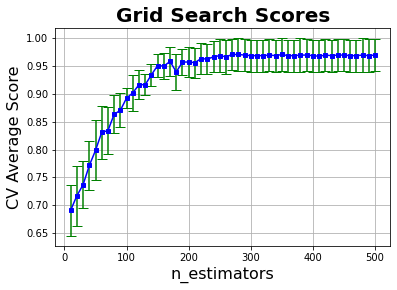

In [9]:
lst =  list(np.linspace(10, 500, 50, dtype=int))
# Grid Search application
# The max depth will be the value encountered in Decision Tree test
grid_params_gradient_boosting = [{'n_estimators': lst}]
ab = AdaBoost()
clf = GridSearchCV(ab, grid_params_gradient_boosting, scoring='accuracy', refit=True, cv=5, verbose=1)
# Run fit with all sets of parameters.
clf.fit(X, y)
# Results of Grid Search
n_estimators  = clf.best_params_['n_estimators']
score = clf.best_score_
print("The best mean accuracy was " + '{:.4f}'.format(score) + " and was achieved for n_estimators = " + str(n_estimators) )
plot_grid_search(clf.cv_results_, lst, 'n_estimators')

Uma vez definido o parâmetro correspondente ao número de estimadores do AdaBoost, o modelo foi novamente testado na base de dados Tic-Tac-Toe, utilizando a metodologia de validação cruzada com 5 partições. Além da taxa de erro simples (requisitada na descrição do trabalho), nesse teste foram calculadas a acurácia, a precisão e o *recall*:

  - $Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$
  - $Precision = \frac{TP}{TP + FP}$
  - $Recall = \frac{TP}{TP + FN}$
 
sendo:
  - True Positive (TP):  A classe positiva real é prevista como positiva.
  - True Negative (TN):  A classe negativa real é prevista negativa.
  - False Positive (FP): A classe real é negativa, mas prevista como positiva.
  - False Negative (FN): A classe real é positiva, mas prevista como negativa.
  

É possível notar que o modelo obteve um ótimo resultado, com um erro médio inferior a 1,8%,  uma precisão média acima de 97% e um *recall* médio próximo de 100%. Os valores de precisão e *recall* podem facilmente serem entendido ao se observar a matriz de confusão. No total o modelo cometeu 16 erros de Falso Positivo, enquanto obteve apenas 1 erro de Falso Negativo.     Também pela matriz de confusão nota-se o bom resultado do modelo, uma vez que a diagonal principal possui valores consideravelmente maiores que o restante dessa matriz.

Accuracy (fold 0): 0.9740
Accuracy (fold 1): 0.9583
Accuracy (fold 2): 0.9948
Accuracy (fold 3): 0.9843
Accuracy (fold 4): 1.0000
Mean Error Rate: 0.0177+/-0.0149
Mean Accuracy: 0.9823+/-0.0149
Mean Precision: 0.9757+/-0.0221
Mean Recall: 0.9984+/-0.0031


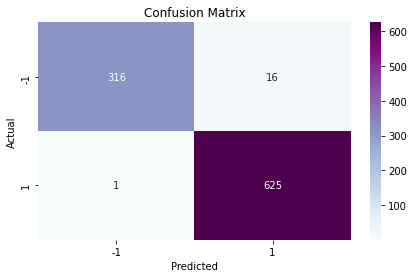

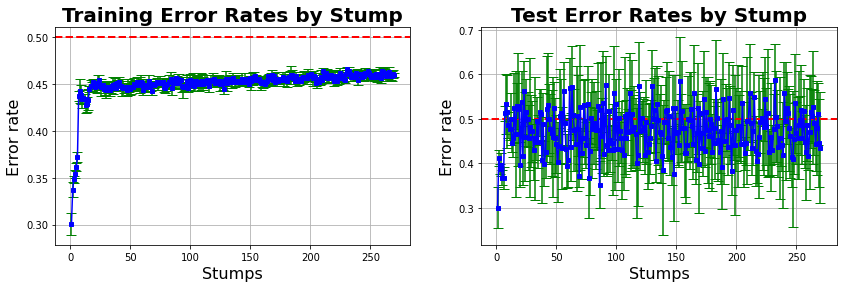

In [10]:
# Calling Method 
model =  AdaBoost
params = {'n_estimators': n_estimators}
clf = apply_cross_validation(X, y, model, params, plot_error_stump=True)

Os dois gráficos acima correspondem a taxa de erro para cada classificador fraco. Cada valor do gráfico corresponde a uma média obtida da validação cruzada, enquanto as barras de erro correspondem aos respectivos desvios padrão.

No gráfico da esquerda tem-se a taxa de erro por classificador fraco (ou iteração) considerando apenas os dados de treinamento. Como se sabe, o AdaBoost se encaixa em um conjunto de classificadores fracos. Para ver o que isso significa na prática, buscou-se visualizar as taxas de erro para cada um dos *stumps*. No gráfico da esquerda (acima), nota-se um que a maioria dos classificadores fracos apresentam taxas de erro muito próximas, mas abaixo de 0,5 no conjunto de treinamento. Isso reflete exatamente o conceito de classificadores fracos, que são modelos com desempenho ligeiramente melhor do que classificação aleatória.

Esse mesmo comportamento é notável no gráfico da direita, relativo a taxa de erro considerando os dados de teste. Nota-se que a maioria dos estimadores obteve uma taxa de erro média de teste próxima a 50\%. Na verdade, em alguns deles temos uma performance pior do que uma classificação aleatória. Contudo, como visto, a combinação desses estimadores gerou um modelo com um erro médio abaixo de 1,8\%.

## Aplicação do AdaBoost do pacote sklearn 

O algoritmo AdaBoost do pacote Scikit-learn foi utilizado para comparar e avaliar a performance da implementação do AdaBoost realizada neste trabalho. Abaixo é possível notar uma performance muito semelhante da obtida pelo modelo implementado. Pequenas variações nos resultados são devidas a sementes aleatórias e heurísticas de aproximação.

Accuracy (fold 0): 0.9635
Accuracy (fold 1): 0.9583
Accuracy (fold 2): 0.9948
Accuracy (fold 3): 0.9843
Accuracy (fold 4): 0.9948
Mean Error Rate: 0.0209+/-0.0154
Mean Accuracy: 0.9791+/-0.0154
Mean Precision: 0.9755+/-0.0222
Mean Recall: 0.9935+/-0.0063


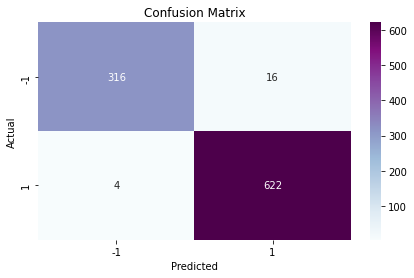

In [11]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier
params = {'n_estimators': n_estimators}
clf = apply_cross_validation(X, y, model, params)

## Gradient Boosting

À titulo de comparação outro algoritmo de Boosting foi aplicado ao problema, o Gradient Boosting. Nota-se abaixo que esse algoritmo obteve também uma performance similar ao do AdaBoost, com uma pequena melhora no desempenho, principalmente considerando a métrica de precisão.  

Fitting 5 folds for each of 50 candidates, totalling 250 fits
The best mean accuracy was 0.8561 and was achieved for n_estimators = 170


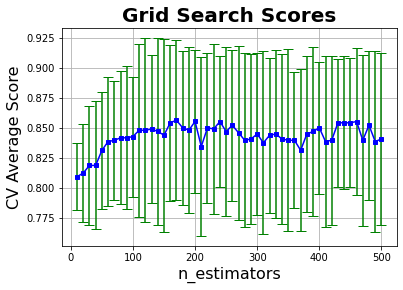

In [12]:
# Grid Search application
# The max depth will be the value encountered in Decision Tree test
grid_params_gradient_boosting = [{'n_estimators': lst}]
gradient_boosting = GradientBoostingClassifier(max_depth = 6)
clf = GridSearchCV(gradient_boosting, grid_params_gradient_boosting, scoring='accuracy', refit=True, cv=5, verbose=1)
# Run fit with all sets of parameters.
clf.fit(X, y)
# Results of Grid Search
n_estimators  = clf.best_params_['n_estimators']
score = clf.best_score_
print("The best mean accuracy was " + '{:.4f}'.format(score) + " and was achieved for n_estimators = " + str(n_estimators) )
plot_grid_search(clf.cv_results_, lst, 'n_estimators')

Accuracy (fold 0): 0.9896
Accuracy (fold 1): 0.9688
Accuracy (fold 2): 1.0000
Accuracy (fold 3): 0.9738
Accuracy (fold 4): 1.0000
Mean Error Rate: 0.0136+/-0.0130
Mean Accuracy: 0.9864+/-0.0130
Mean Precision: 0.9815+/-0.0172
Mean Recall: 0.9983+/-0.0034


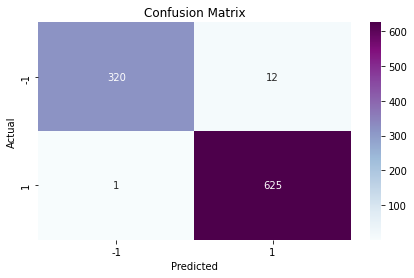

In [13]:
model = GradientBoostingClassifier
params = {'n_estimators' : n_estimators, "max_depth" : 6}
clf = apply_cross_validation(X, y, model, params)